<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/resp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization using the Response surface method

In this example, we will use the Response surface method with a factorial design to optimize the multivariable problem.

Again consider an enzyme reactor, where a certain chemical substance is produced. Through a screening experimental design, three variables were found to significantly affect the yield. The task nos is to use this information and optimize the yield of the product. The variables that had the highest effects in the screening tests are ‘Temperature’, ’pH’, and ’Amount of enzyme’. The range of the settings for these variables are:

Temp = 20-45 ($^o$C) pH = 5-9 Amount = 5-25 (mg)

As ususal, we start by importing the libraries we need.

In [2]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

The yield is calcualted using a function (experiment) taking the variables as input in the form of a list (X). The output from this function is the yield (response). This is given below:

In [3]:
def experiment(X):
  Xspan=[25, 4, 20]
  Xmin=[20, 5, 5]
  Xscale=[]
  for a, b,c in zip(X, Xmin,Xspan):
    Xscale.append((a-b)/c)

  koeff=[[0.643, -0.686, -0.341], [0.704, 0.704, -0.087], [0.3, -0.184, 0.936]]
  koeff=np.array(koeff)

  max1=[0.21, 0.77, 0.68]
  cent1=[]
  for a,b in zip(Xscale, max1):
    cent1.append(a-b)

  koord1=np.matmul(koeff.T, cent1)
  max2=[0.73, 0.42, 0.19]
  cent2=[]
  for a, b in zip(Xscale, max2):
    cent2.append(a-b)

  Resp1=8/(0.1+2*koord1[0]*koord1[0]+0.5*koord1[1]*koord1[1]+0.9*koord1[2]*koord1[2])
  Resp2=1/(0.05+10*(np.sum(np.square(cent2), axis=0)))
  Resp=(15+Resp1+Resp2)+0.1*(rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand())
  return Resp


The first step is to choose initial values for our DoE. This ranges should be choosen large enough to give us as much information as possible, but still small enough to be "close to linear" with respect to our main variables. Let's start with the same data as we used in the simplex optimization problem:

In [4]:
# first try
#create list of data for high and low.
dat = [('T',20, 21.5, 23),
       ('p',5, 5.2, 5.4),
       ('A', 15, 15.8, 16.6)]

and create the matrices for out experimental design:

In [5]:
inputs_labels = {'T' : 'Temperature',
                 'p' : 'pH',
                 'A':'Amount'}



# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
T,20,21.5,23.0,Temperature
p,5,5.2,5.4,pH
A,15,15.8,16.6,Amount


In [6]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
T,20,21.5,23.0,Temperature,-1.0,0.0,1.0
p,5,5.2,5.4,pH,-1.0,0.0,1.0
A,15,15.8,16.6,Amount,-1.0,0.0,1.0


In [7]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1], [-1,1]))
encoded_inputs
for i in range(0,1):
    encoded_inputs.append((0,0,0))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1),
 (0, 0, 0)]

Our design matrix in scaled variables will look like this:

In [8]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['T','p', 'A']
results

,T,p,A
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1
8,0,0,0


To get the actual values for the experiment, we need to convert the design matrix to real values:

In [9]:
real_experiment = results
var_labels = []
for var in ['T','p', 'A']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),
        axis=1)



print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Temperature,pH,Amount
0,20.0,5.0,15.0
1,23.0,5.0,15.0
2,20.0,5.4,15.0
3,23.0,5.4,15.0
4,20.0,5.0,16.6
5,23.0,5.0,16.6
6,20.0,5.4,16.6
7,23.0,5.4,16.6
8,21.5,5.2,15.8


These values are the ones we send to do the experiemnts:

In [10]:
resp=[]
for i in range(len(real_experiment.index)):
   X=[real_experiment.Temperature[i], real_experiment.pH[i],real_experiment.Amount[i]]
   resp.append(experiment(X))

results['y']= resp
results

,T,p,A,Temperature,pH,Amount,y
0,-1,-1,-1,20.0,5.0,15.0,21.534200
1,1,-1,-1,23.0,5.0,15.0,22.869809
2,-1,1,-1,20.0,5.4,15.0,23.150574
3,1,1,-1,23.0,5.4,15.0,24.629468
4,-1,-1,1,20.0,5.0,16.6,21.768817
5,1,-1,1,23.0,5.0,16.6,23.139791
6,-1,1,1,20.0,5.4,16.6,23.498538
7,1,1,1,23.0,5.4,16.6,25.063857
8,0,0,0,21.5,5.2,15.8,23.041324


The next step is to fit a response surface to the data, using the linear terms:

In [11]:
y1 = results['y']
xlabs=['T','p','A']
x = results[xlabs]


res1 = smf.ols(formula='y ~ T + p + A', data=results).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     347.6
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           3.20e-06
Time:                        14:30:20   Log-Likelihood:                 10.559
No. Observations:                   9   AIC:                            -13.12
Df Residuals:                       5   BIC:                            -12.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.1885      0.033    692.637      0.000      23.102      23.275
T              0.7188      0.036     20.244      0.000       0.628       0.810
p              0.8787      0.036     24.746      0.000       0.787       0.970
A              0.1609      0.036      4.530      0.006       0.070       0.252
==============================================================================
Omnibus:                        0.529   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.062
Skew:                          -0.166   Prob(JB):                        0.969
Kurtosis:                       2.766   Cond. No.                         1.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that we have 5 Degrees of freedom to to evaluate the residuals. All parameters are significant. The coefficients are in this model the gradients we should follow. We note that the gradients are quite small (smaller than one) which either imply that we are close to a maximum, or, that we are far from the maximum. We can now use these gradients to suugest new experiments

We can plot the data predicted Yield with the meaured ones:

Text(0.5, 0, 'experiment')

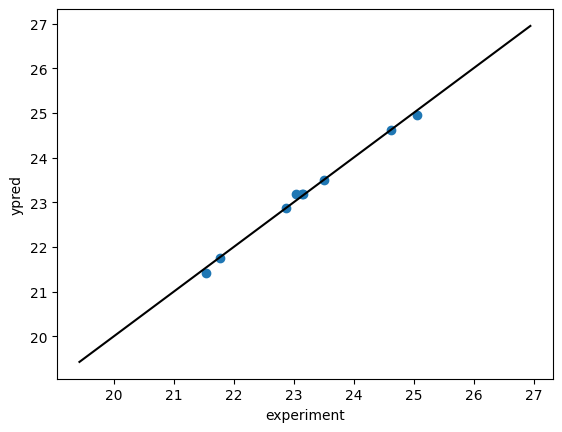

In [12]:
ypred=res1.predict(x)
plt.scatter(results['y'],ypred)
x=np.linspace(min(ypred)-2,max(ypred)+2,101)

plt.plot(x,x,'k-') # identity line

plt.ylabel('ypred')
plt.xlabel('experiment')


Within the range of our variables, we have a good description of our experiment.

This leaves with the first order model: ybar = 23.1974 + 0.6235T + 0.8779p +0.2227A (note that there is a randomness in the experimental values, your model might not be the same as mine)  

So, now, for any T, p and A, we can predict y.

If we move 0.6235 steps in the direction of T, 0.8779 in the direction of p, and 0.2227 in the direction of pH and A, this will be the direction of steepest ascent. All we know is that this flat surface is one side of the "hill" forming our maxima.

With the method of steepest descent, we can now start marching up the hill taking additional measurements at each (T,pH, A) until the response starts to decrease. If we start at 0 (in coded units), then we can do series of single experiments as suggested by the model on this path up the hill of the steepest ascent. At all points, we can compare how the model performs and calcualte an error. When the error is to large, we need to repeat the DoE and create a new model. The stepsize is choosen based on our experience. If we do not have that, a suitable way is to perform a few experiment with large steps in the beginning, and then make the step size smaller when we now we are closer to the maxima.



The box below performs a march in the direction of the steepest ascent wiht stepsize delta_in_T. The number of experiments is nexp.

In [13]:
delta_in_T=1
nexp=3
Origin = [results['T'].iloc[8], results['p'].iloc[8], results['A'].iloc[8]]
coeff= res1.params
delta=delta_in_T*[coeff[1]/coeff[1],coeff[2]/coeff[1],coeff[3]/coeff[1] ]

marchT=[Origin[0]];marchp=[Origin[1]];marcha=[Origin[2]]


for i in range(0,nexp):
    marchT.append(Origin[0]+(i+1)*delta[0])
    marchp.append(Origin[1]+(i+1)*delta[1])
    marcha.append(Origin[1]+(i+1)*delta[2])

March=pd.DataFrame({'T':marchT, 'p':marchp, 'A':marcha})
ypred=res1.predict(March)

March['ypred']=ypred
March





<ipython-input-13-22f8333243b5>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta=delta_in_T*[coeff[1]/coeff[1],coeff[2]/coeff[1],coeff[3]/coeff[1] ]


,T,p,A,ypred
0,0.0,0.000000,0.000000,23.188486
1,1.0,1.222408,0.223787,25.017500
2,2.0,2.444816,0.447573,26.846513
3,3.0,3.667224,0.671360,28.675527


Then, we do do the real experiments:

In [14]:
# Lets do the real experiment
#assume we take steps in T

Origin_real=[results['Temperature'].iloc[8], results['pH'].iloc[8], results['Amount'].iloc[8]]
marchT_real=[Origin_real[0]];marchp_real=[Origin_real[1]];marcha_real=[Origin_real[2]]

for i in range(1,len(March)):
    marchT_real.append(Origin_real[0]+(i+1)*delta[0])
    marchp_real.append(Origin_real[1]+(i+1)*delta[1])
    marcha_real.append(Origin_real[2]+(i+1)*delta[2])

March_real=pd.DataFrame({'Temperature':marchT_real, 'pH':marchp_real, 'Amount':marcha_real})

resp=[]
for i in range(len(March_real)):
   X=[March_real.Temperature[i], March_real.pH[i],March_real.Amount[i]]
   resp.append(experiment(X))
March_real['y_real']=resp
March_real

,Temperature,pH,Amount,y_real
0,21.5,5.200000,15.800000,23.301147
1,23.5,7.644816,16.247573,67.066354
2,24.5,8.867224,16.471360,71.808498
3,25.5,10.089632,16.695147,34.972559


we see that the direction of steepest descent takes in the right direction, but the model deviate strongly with the experiment. We can also plot the data:

and plot the results:

<Axes: >

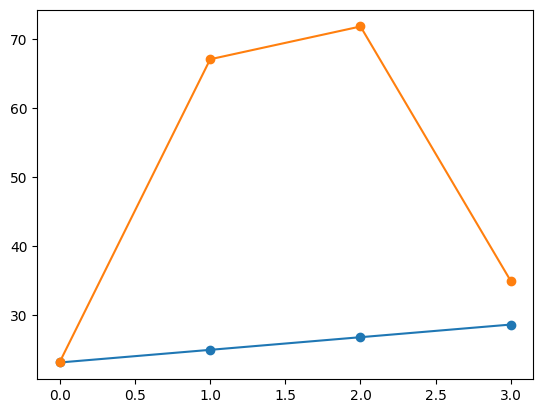

In [15]:
March['ypred'].plot(marker='o')
March_real['y_real'].plot(marker='o')


Based on this plot, we make a new DoE around our maximum. First we identify the experimental settings for the maximum in our experiments followed by defining new high and low points for our variables.

In [16]:
max=March_real['y_real'].sort_values(ascending=False).index[0]
# second try
dT=2
dp=0.5
dA=1
#create list of data for high and low.
dat = [('T',March_real.iloc[max].Temperature-dT, March_real.iloc[max].Temperature, March_real.iloc[max].Temperature+dT),
        ('p', March_real.iloc[max].pH-dp, March_real.iloc[max].pH,  March_real.iloc[max].pH+dp),
        ('A',March_real.iloc[max].Amount-dA, March_real.iloc[max].Amount, March_real.iloc[max].Amount+dA )]

Then we redo the process again...

In [17]:
inputs_labels = {'T' : 'Temperature',
                 'p' : 'pH',
                 'A':'Amount'}



# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df


,low,center,high,label
index,,,,
T,22.500000,24.500000,26.500000,Temperature
p,8.367224,8.867224,9.367224,pH
A,15.471360,16.471360,17.471360,Amount


In [18]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df


,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
T,22.500000,24.500000,26.500000,Temperature,-1.0,0.0,1.0
p,8.367224,8.867224,9.367224,pH,-1.0,0.0,1.0
A,15.471360,16.471360,17.471360,Amount,-1.0,0.0,1.0


In this step, we add a few more centerpoints to evaluate the experimental error in our setup.

In [19]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1], [-1,1]))
encoded_inputs
for i in range(0,5):
    encoded_inputs.append((0,0,0))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0)]

In [20]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['T','p', 'A']
results

,T,p,A
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1
8,0,0,0
9,0,0,0


In [21]:
real_experiment = results
var_labels = []
for var in ['T','p', 'A']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),
        axis=1)

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Temperature,pH,Amount
0,22.5,8.367224,15.47136
1,26.5,8.367224,15.47136
2,22.5,9.367224,15.47136
3,26.5,9.367224,15.47136
4,22.5,8.367224,17.47136
5,26.5,8.367224,17.47136
6,22.5,9.367224,17.47136
7,26.5,9.367224,17.47136
8,24.5,8.867224,16.47136
9,24.5,8.867224,16.47136


and finally perform the experiments:

In [22]:
resp=[]
for i in range(len(real_experiment.index)):
   X=[real_experiment.Temperature[i], real_experiment.pH[i],real_experiment.Amount[i]]
   resp.append(experiment(X))

results['y']= resp
results

,T,p,A,Temperature,pH,Amount,y
0,-1,-1,-1,22.5,8.367224,15.47136,75.302523
1,1,-1,-1,26.5,8.367224,15.47136,76.923059
2,-1,1,-1,22.5,9.367224,15.47136,55.944915
3,1,1,-1,26.5,9.367224,15.47136,47.619288
4,-1,-1,1,22.5,8.367224,17.47136,86.272506
5,1,-1,1,26.5,8.367224,17.47136,85.189788
6,-1,1,1,22.5,9.367224,17.47136,57.240551
7,1,1,1,26.5,9.367224,17.47136,47.535591
8,0,0,0,24.5,8.867224,16.47136,71.582644
9,0,0,0,24.5,8.867224,16.47136,71.528094


And we fit a linear model using statmodels

In [23]:
y2 = results['y']
xlabs=['T','p','A']
x = results[xlabs]


res2 = smf.ols(formula='y ~ T + p + A', data=results).fit()

res2.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     31.29
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           4.32e-05
Time:                        14:30:21   Log-Likelihood:                -35.085
No. Observations:                  13   AIC:                             78.17
Df Residuals:                       9   BIC:                             80.43
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.4896      1.199     57.133      0.000      65.778      71.201
T             -2.1866      1.528     -1.431      0.186      -5.643       1.270
p            -14.4184      1.528     -9.435      0.000     -17.875     -10.962
A              2.5561      1.528      1.673      0.129      -0.901       6.013
==============================================================================
Omnibus:                        2.805   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.246   Jarque-Bera (JB):                1.842
Skew:                          -0.897   Prob(JB):                        0.398
Kurtosis:                       2.570   Cond. No.                         1.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0, 'experiment')

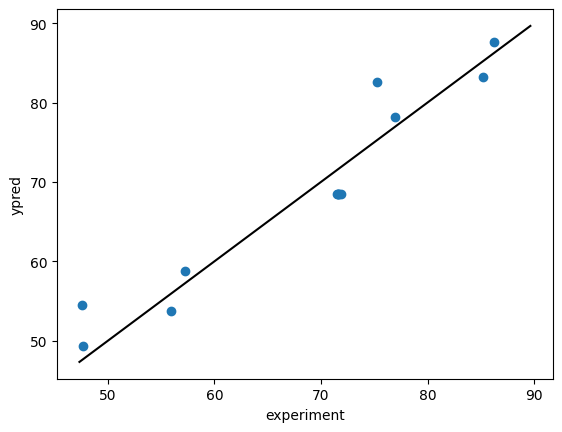

In [24]:
ypred=res2.predict(x)
plt.scatter(results['y'],ypred)
xn=np.linspace(np.min(ypred)-2,np.max(ypred)+2,101)

plt.plot(xn,xn,'k-') # identity line

plt.ylabel('ypred')
plt.xlabel('experiment')

Here we see that the model is not any longer well approximated with a linear fit. This implieas that we most likely identified our maxima.

By doing the repeated experiments, we now also have the possibility to evalueate the experimental errror:

In [25]:
exp_repeat=results['y'][8:13]
print('mean=', exp_repeat.mean(), 'std=', exp_repeat.std(), 'var=', exp_repeat.var())

mean= 71.66742364299675 std= 0.13643784994391597 var= 0.01861528689731853


As we see, the experomental errior is small. We keep this values in mind when going to the next step, which is to use a higher order model.

When ready, use higher order model...


In [26]:
res3 = smf.ols(formula='y ~ T + p + A + T:p +T:A + p:A + I(T**2) + I(p**2)', data=results).fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4675.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           3.13e-09
Time:                        14:30:21   Log-Likelihood:                 6.1929
No. Observations:                  13   AIC:                             3.614
Df Residuals:                       5   BIC:                             8.134
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     71.6674      0.108    661.372      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


Text(0.5, 0, 'experiment')

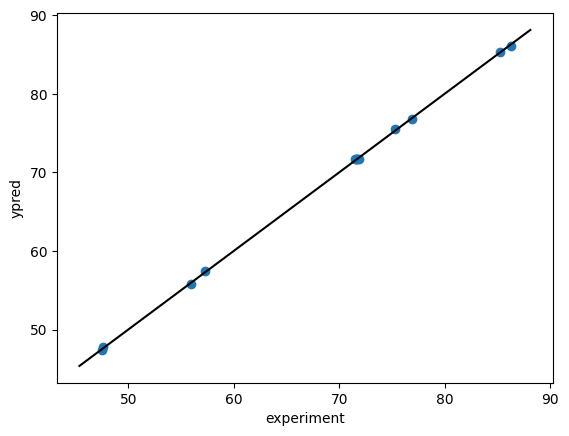

In [27]:
ypred=res3.predict(x)
plt.scatter(results['y'],ypred)
xn=np.linspace(np.min(ypred)-2,np.max(ypred)+2,101)

plt.plot(xn,xn,'k-') # identity line

plt.ylabel('ypred')
plt.xlabel('experiment')

We note that the maxima lies in a corner of our box, and our model has limited validity outside the box. Therefore, we expand around the maximum and perform a DoE using a Latin Hypercube design. We use the input variables as the left lower corner and generate new data points:

In [28]:
!pip install doepy

In [29]:
results


,T,p,A,Temperature,pH,Amount,y
0,-1,-1,-1,22.5,8.367224,15.47136,75.302523
1,1,-1,-1,26.5,8.367224,15.47136,76.923059
2,-1,1,-1,22.5,9.367224,15.47136,55.944915
3,1,1,-1,26.5,9.367224,15.47136,47.619288
4,-1,-1,1,22.5,8.367224,17.47136,86.272506
5,1,-1,1,26.5,8.367224,17.47136,85.189788
6,-1,1,1,22.5,9.367224,17.47136,57.240551
7,1,1,1,26.5,9.367224,17.47136,47.535591
8,0,0,0,24.5,8.867224,16.47136,71.582644
9,0,0,0,24.5,8.867224,16.47136,71.528094


In [30]:
from doepy import read_write, build
lhs=build.space_filling_lhs(
{'Temperature':[25.5, 27],
'pH':[8.2307, 8.5],
 'Amount': [17.652903, 18.2]},
num_samples = 15
)

we perform the experiments

In [31]:
resp=[]
results_lhs=lhs
for i in range(len(lhs)):
  resp.append(experiment([lhs['Temperature'][i],lhs['pH'][i], lhs['Amount'][i]]))

results_lhs['Response']=resp
results_lhs

,Temperature,pH,Amount,Response
0,25.607143,8.384586,17.731060,88.644081
1,26.142857,8.326879,18.200000,88.747288
2,26.464286,8.365350,17.926451,85.976561
3,25.714286,8.288407,17.809216,91.262821
4,27.000000,8.423057,18.043687,80.696836
5,25.500000,8.500000,18.121843,85.166201
6,26.785714,8.249936,18.082765,87.924602
7,26.357143,8.461529,18.160922,82.666347
8,25.821429,8.230700,18.004608,92.420027
9,26.678571,8.442293,17.887373,81.722469


In [32]:
res4 = smf.ols(formula='Response ~ Temperature + pH + Amount + I(Temperature**2) + I(pH**2) + I(Amount**2)', data=results_lhs).fit()
print(res4.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     497.0
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           7.65e-10
Time:                        14:30:25   Log-Likelihood:                 3.8438
No. Observations:                  15   AIC:                             6.312
Df Residuals:                       8   BIC:                             11.27
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -482.5477   1

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


With this model, we can find the optimal position visually by plotting the fitted function. Here I use a brute force method just using very many random variables. Can you use another way?

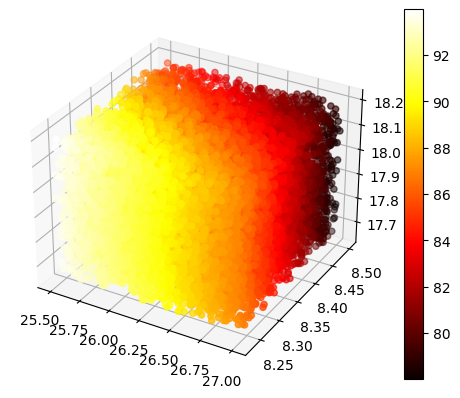

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

{'Temperature':[25.5, 27],
'pH':[8.2307, 8.5],
 'Amount': [17.652903, 18.2]},

Temperature = np.random.uniform(25.5, 27, 15000)
pH = np.random.uniform(8.2307, 8.5, 15000)
Amount = np.random.uniform(17.652903, 18.2, 15000)


data=pd.DataFrame({'Temperature':Temperature, 'pH':pH, 'Amount':Amount})

c = res4.predict(data)
data['ypred']=c
img = ax.scatter(Temperature, pH, Amount, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

and find the input values for the maximum yeld as obtained from the model:

In [38]:
data['ypred'].idxmax()
data.iloc[data['ypred'].idxmax()]

,9164
Temperature,25.510662
pH,8.235164
Amount,18.192550
ypred,93.975702


The last test is to perform the experiment that validate our finding:

In [39]:
experiment([data.iloc[data['ypred'].idxmax()]['Temperature'],data.iloc[data['ypred'].idxmax()]['pH'],data.iloc[data['ypred'].idxmax()]['Amount']])

93.10870195675145

Here, I'll guess that we are satisfied with this result. We have used the response surface model and found a maximum according to our model. Depending on the "cost" of performing experiments, we can of course continue to refine our model with more experimental data, but for the case of this tutorial, we stop here.